# Import Libraries

In [364]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [365]:
!pip install imbalanced-learn


Defaulting to user installation because normal site-packages is not writeable


In [366]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression



In [367]:
from imblearn.over_sampling import RandomOverSampler


# Prepares the dataset


## Read dataset

In [368]:
df = pd.read_csv("full_data.csv")

## Preprocessing + EDA


In [369]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [370]:
df.columns


Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [371]:
df.dtypes


gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

df.isnull().sum()


In [372]:
df.isnull().sum()


gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

/tmp/ipykernel_42767/2157429118.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


<Axes: >

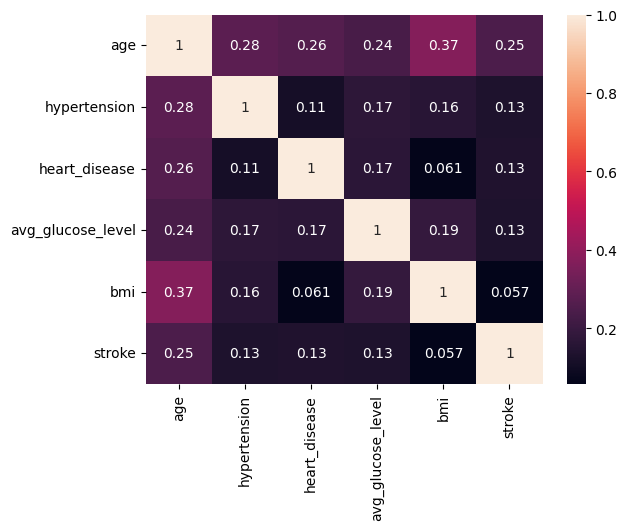

In [373]:
sns.heatmap(df.corr(),annot=True)


### BMI analysis


<Axes: xlabel='bmi', ylabel='Count'>

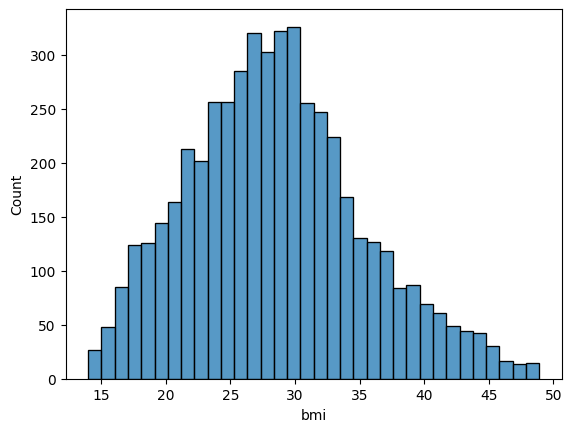

In [374]:
sns.histplot(data=df['bmi'])


<Axes: >

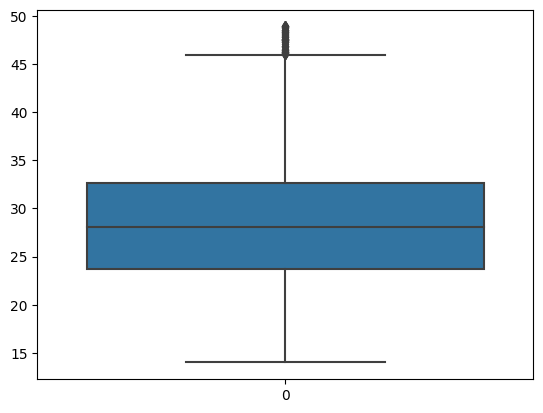

In [375]:
sns.boxplot(data=df['bmi'])


- The age parameter values does not have any outliers
- And has a normal distribution

### Age

<Axes: xlabel='age', ylabel='Count'>

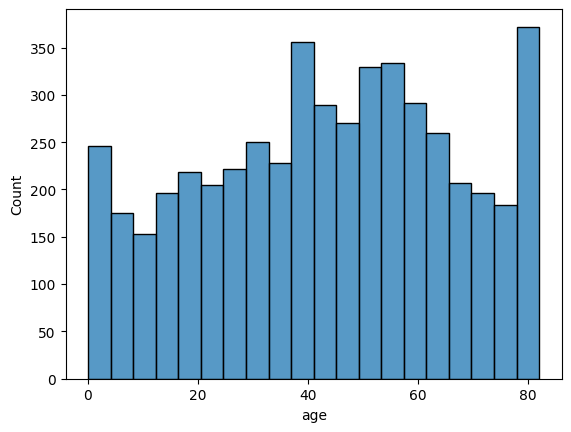

In [376]:
sns.histplot(data=df['age'])


<Axes: >

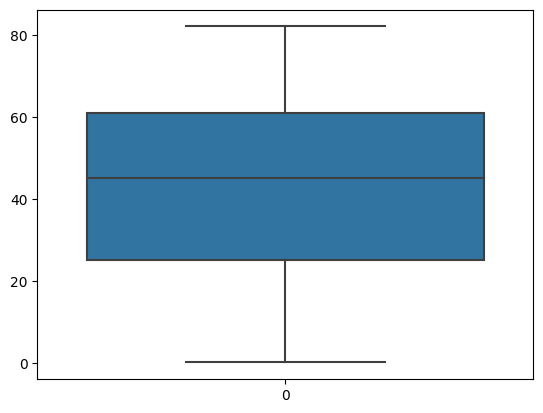

In [377]:
sns.boxplot(data=df['age'])


### AVERAGE GLUCOSE LEVEL ANALYSIS


<Axes: xlabel='avg_glucose_level', ylabel='Count'>

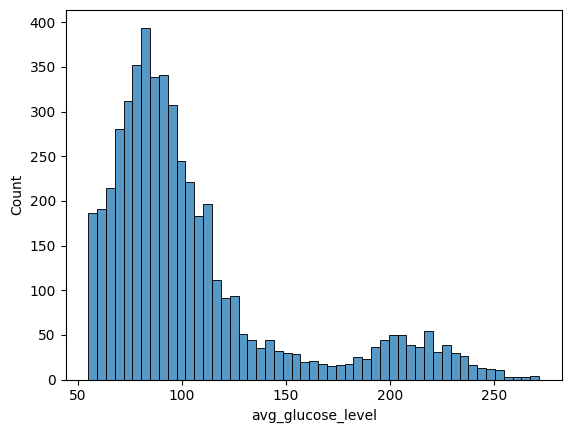

In [378]:
sns.histplot(data=df['avg_glucose_level'])


- avg_glucose_level is rightly skewed

<Axes: >

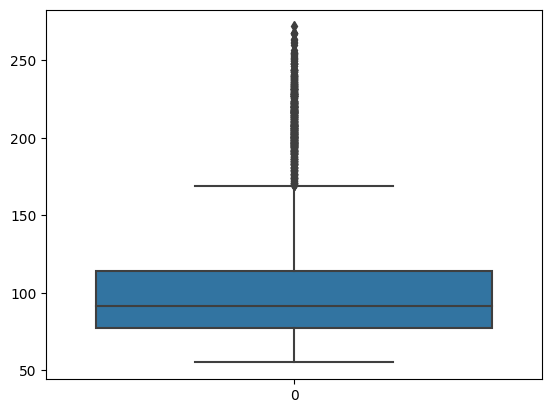

In [379]:
sns.boxplot(data=df['avg_glucose_level'])


In [380]:
# Finding the count of outliers based on those instances which are out of iqr 
Q1 = df['avg_glucose_level'].quantile(0.25)
Q3 = df['avg_glucose_level'].quantile(0.75)
# Finding IQR
IQR = Q3 - Q1
da=(df['avg_glucose_level'] < (Q1 - 1.5 * IQR)) | (df['avg_glucose_level'] > (Q3 + 1.5 * IQR))
da.value_counts()


False    4379
True      602
Name: avg_glucose_level, dtype: int64

### Work type analysis

In [381]:
df['work_type'].value_counts()


Private          2860
Self-employed     804
children          673
Govt_job          644
Name: work_type, dtype: int64

<Axes: ylabel='work_type'>

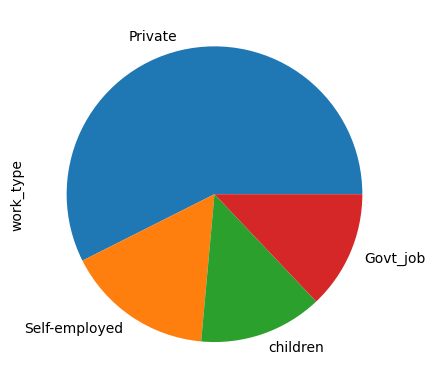

In [382]:
df['work_type'].value_counts().plot(kind="pie")


### Ever_married analysis

In [383]:
df['ever_married'].value_counts()


Yes    3280
No     1701
Name: ever_married, dtype: int64

<Axes: ylabel='ever_married'>

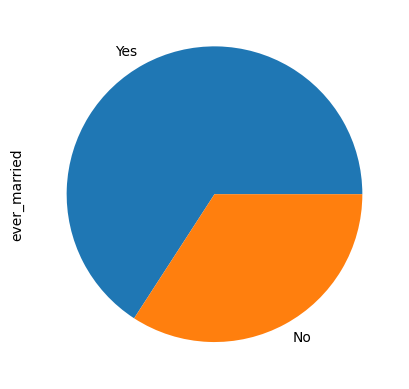

In [384]:
df['ever_married'].value_counts().plot(kind="pie")


### Smoking status analysis

In [385]:
df['smoking_status'].value_counts()


never smoked       1838
Unknown            1500
formerly smoked     867
smokes              776
Name: smoking_status, dtype: int64

- The unknown status can't help in the model, so we should drop it now 

In [386]:
df = df[df.smoking_status != "Unknown"]

In [387]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0


<Axes: ylabel='smoking_status'>

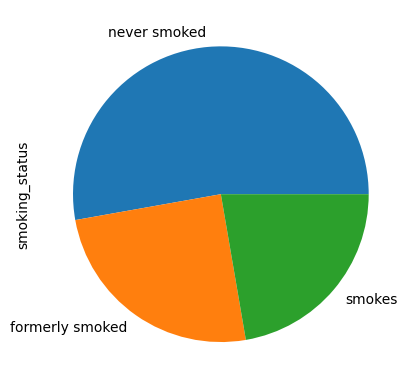

In [388]:
df['smoking_status'].value_counts().plot(kind="pie")


### Target feature - Stroke

In [389]:
# Value count in the stroke attribute
df['stroke'].value_counts()


0    3280
1     201
Name: stroke, dtype: int64

<Axes: >

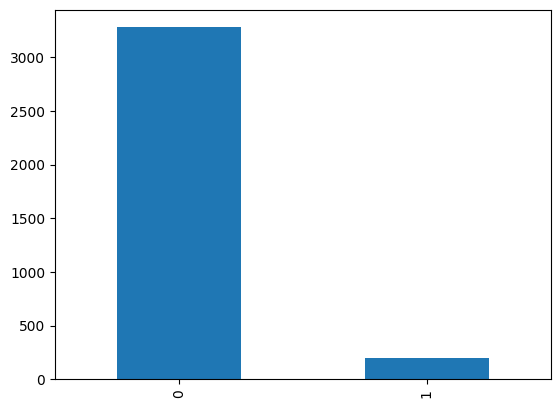

In [390]:
df['stroke'].value_counts().plot(kind="bar")


In [391]:
print("% of people who actualy got a stroke : ",(df['stroke'].value_counts()[1]/df['stroke'].value_counts().sum()).round(3)*100)


% of people who actualy got a stroke :  5.800000000000001


## Normalize data

### One hot encoding for categorical data

In [392]:
# Converting numeric-binary value attributes to string
df[['hypertension', 'heart_disease', 'stroke']] = df[['hypertension', 'heart_disease', 'stroke']].astype(str)
# Generating dummy attributes - one hot encoding format
df = pd.get_dummies(df, drop_first= True)


In [393]:
df.head()


,age,avg_glucose_level,bmi,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes,stroke_1
0,67.0,228.69,36.6,1,0,1,1,1,0,0,1,0,0,1
1,80.0,105.92,32.5,1,0,1,1,1,0,0,0,1,0,1
2,49.0,171.23,34.4,0,0,0,1,1,0,0,1,0,1,1
3,79.0,174.12,24.0,0,1,0,1,0,1,0,0,1,0,1
4,81.0,186.21,29.0,1,0,0,1,1,0,0,1,0,0,1


In [394]:
df.columns

Index(['age', 'avg_glucose_level', 'bmi', 'gender_Male', 'hypertension_1',
       'heart_disease_1', 'ever_married_Yes', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_never smoked', 'smoking_status_smokes', 'stroke_1'],
      dtype='object')

In [395]:
# Performing a minority oversampling
oversample = RandomOverSampler(sampling_strategy='minority')
X=df.drop(['stroke_1'],axis=1)
y=df['stroke_1']

# Obtaining the oversampled dataframes - testing and training
X_over, y_over = oversample.fit_resample(X, y)


In [425]:
X_over

,age,avg_glucose_level,bmi,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes
0,67.0,228.69,36.6,1,0,1,1,1,0,0,1,0,0
1,80.0,105.92,32.5,1,0,1,1,1,0,0,0,1,0
2,49.0,171.23,34.4,0,0,0,1,1,0,0,1,0,1
3,79.0,174.12,24.0,0,1,0,1,0,1,0,0,1,0
4,81.0,186.21,29.0,1,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6555,78.0,235.63,32.3,0,0,0,1,1,0,0,0,1,0
6556,52.0,96.59,26.4,0,0,0,1,1,0,0,0,1,0
6557,69.0,182.99,36.5,1,1,0,0,1,0,0,0,1,0
6558,46.0,78.18,30.8,0,0,0,1,1,0,0,1,1,0


In [396]:
from sklearn.preprocessing import StandardScaler

# Since the numeric attributes in the dataset is in different ranges and three are outliers persent we are usign a scaler to get all the values into the same range.
s = StandardScaler()
# Scaling the numeric attributes
df[['bmi', 'avg_glucose_level', 'age']] = s.fit_transform(df[['bmi', 'avg_glucose_level', 'age']])


In [397]:
df

,age,avg_glucose_level,bmi,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes,stroke_1
0,0.949234,2.491781,1.090636,1,0,1,1,1,0,0,1,0,0,1
1,1.637373,-0.059201,0.432257,1,0,1,1,1,0,0,0,1,0,1
2,-0.003574,1.297846,0.737359,0,0,0,1,1,0,0,1,0,1,1
3,1.584439,1.357896,-0.932676,0,1,0,1,0,1,0,0,1,0,1
4,1.690306,1.609108,-0.129774,1,0,0,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,-0.427043,-0.802450,-0.001310,1,0,0,0,1,0,0,0,0,0,0
4977,-0.479977,1.711754,0.207444,1,0,0,1,1,0,0,1,0,1,0
4978,-0.215309,-0.285687,0.319850,0,1,0,1,0,0,0,0,0,1,0
4979,-0.479977,-0.515914,0.030806,1,0,0,1,1,0,0,0,0,1,0


In [398]:
def precessingData(df):
    df[['hypertension', 'heart_disease']] = df[['hypertension', 'heart_disease']].astype(str)
    # Generating dummy attributes - one hot encoding format
    df = pd.get_dummies(df, drop_first= True)
    print(df)
    s = StandardScaler()
    # Scaling the numeric attributes
    df[['bmi', 'avg_glucose_level', 'age']] = s.fit_transform(df[['bmi', 'avg_glucose_level', 'age']])
    print(df)
    return df


## Test-train split

In [399]:
from sklearn.model_selection import train_test_split
# Performing a 80-20 test-train split
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size= 0.20, random_state= 42)


In [400]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)


X_train: (5248, 13)
y_train: (5248,)
X_test: (1312, 13)
y_test: (1312,)


# Training Model


In [401]:
# Initialzing empty lists to append all model's name and corresponding name
acc = []
model = []

In [402]:
from sklearn.model_selection import KFold
from sklearn import model_selection

# Performing k fold cross validation using 20 splits
kfold_kridge = model_selection.KFold(n_splits=20, shuffle=True)


## Decision Tree

In [403]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

from sklearn import metrics

DecisionTree = DecisionTreeClassifier(criterion="gini",random_state=2,max_depth=5)

DecisionTree.fit(X_train,y_train)



DecisionTreeClassifier(max_depth=5, random_state=2)

In [404]:
results_kfold = model_selection.cross_val_score(DecisionTree, X_over, y_over, cv=kfold_kridge)
print("Accuracy: ", results_kfold.mean()*100)
acc.append(results_kfold.mean()*100)
model.append('Decision Tree')


Accuracy:  77.92682926829268


In [405]:
predicted_values = DecisionTree.predict(X_test)
print(classification_report(y_test,predicted_values))


              precision    recall  f1-score   support

           0       0.91      0.72      0.81       671
           1       0.76      0.93      0.84       641

    accuracy                           0.82      1312
   macro avg       0.84      0.82      0.82      1312
weighted avg       0.84      0.82      0.82      1312



## Random Forest

In [406]:
from sklearn.ensemble import RandomForestClassifier

RandomForest = RandomForestClassifier(n_estimators=20, random_state=0)
RandomForest.fit(X_train,y_train)


RandomForestClassifier(n_estimators=20, random_state=0)

In [407]:
results_kfold = model_selection.cross_val_score(RandomForest, X_over, y_over, cv=kfold_kridge)
print("Accuracy: ", results_kfold.mean()*100)
acc.append(results_kfold.mean()*100)
model.append('Random Forest')


Accuracy:  99.29878048780488


In [408]:
predicted_values = RandomForest.predict(X_test)
print(classification_report(y_test,predicted_values))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       671
           1       0.98      1.00      0.99       641

    accuracy                           0.99      1312
   macro avg       0.99      0.99      0.99      1312
weighted avg       0.99      0.99      0.99      1312



## Logistic Regression


In [409]:
from sklearn.linear_model import LogisticRegression

LogRegression = LogisticRegression(random_state=0)

LogRegression.fit(X_train,y_train)



/home/hoangtrung/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [410]:
results_kfold = model_selection.cross_val_score(RandomForest, X_over, y_over, cv=kfold_kridge)
print("Accuracy: ", results_kfold.mean()*100)
acc.append(results_kfold.mean()*100)
model.append('Logistic Regression')


Accuracy:  99.3140243902439


In [411]:
predicted_values = LogRegression.predict(X_test)

x = metrics.accuracy_score(y_test, predicted_values)
print(classification_report(y_test,predicted_values))


              precision    recall  f1-score   support

           0       0.76      0.69      0.72       671
           1       0.71      0.77      0.74       641

    accuracy                           0.73      1312
   macro avg       0.73      0.73      0.73      1312
weighted avg       0.73      0.73      0.73      1312



# Support Vector Machine (SVM)


In [412]:
from sklearn.svm import SVC
# data normalization with sklearn
SVM = SVC(kernel='poly', degree=3, C=1)
SVM.fit(X_train,y_train)


SVC(C=1, kernel='poly')

In [413]:
results_kfold = model_selection.cross_val_score(RandomForest, X_over, y_over, cv=kfold_kridge)
print("Accuracy: ", results_kfold.mean()*100)
acc.append(results_kfold.mean()*100)
model.append('Support Vector Machine')


Accuracy:  99.29878048780488


In [414]:
predicted_values = SVM.predict(X_test)
x = metrics.accuracy_score(y_test, predicted_values)
print(classification_report(y_test,predicted_values))


              precision    recall  f1-score   support

           0       0.75      0.73      0.74       671
           1       0.73      0.74      0.73       641

    accuracy                           0.74      1312
   macro avg       0.74      0.74      0.74      1312
weighted avg       0.74      0.74      0.74      1312



In [415]:
model

['Decision Tree',
 'Random Forest',
 'Logistic Regression',
 'Support Vector Machine']

In [416]:
acc

[77.92682926829268, 99.29878048780488, 99.3140243902439, 99.29878048780488]

# Accuracy Comparison


<Axes: title={'center': 'Accuracy Comparison'}, xlabel='Accuracy', ylabel='Algorithm'>

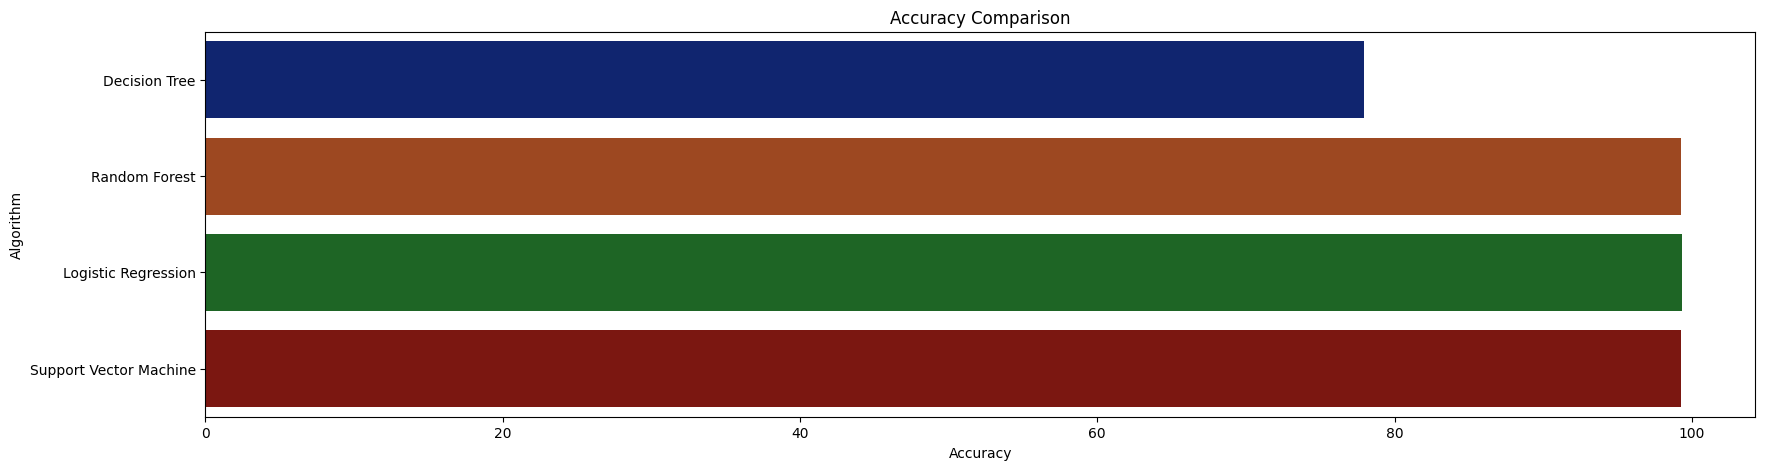

In [417]:
plt.figure(figsize=[20,5],dpi = 100)
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Algorithm')
sns.barplot(x = acc,y = model,palette='dark')


In [418]:
model[acc.index(max(acc))]


'Logistic Regression'

- Support Vector Machine Model has the highest accuracy among all models we build, so we'll save it.

# Save Model

In [419]:
import pickle
# Dump the trained Naive Bayes classifier with Pickle
DT_pkl_filename = './model.pkl'
# Open the file to save as pkl file
DT_Model_pkl = open(DT_pkl_filename, 'wb')
pickle.dump(SVM, DT_Model_pkl)
# Close the pickle instances
DT_Model_pkl.close()


# Predict Data

In [420]:
# Making sample predictions based on manual value entry
age=75
avg_glucose_level=300
bmi=36.6
gender_Male=1
ever_married_Yes=1	
work_type_Private=1	
work_type_Self_employed=0
work_type_children=0	
Residence_type_Urban=1
smoking_status_formerly_smoked=1
smoking_status_never_smoked=0
smoking_status_smokes=0
hypertension_1=1
heart_disease_1=1
input_features = [age ,avg_glucose_level,	bmi	,gender_Male,hypertension_1,	heart_disease_1,ever_married_Yes,	work_type_Private,	work_type_Self_employed,	work_type_children	,Residence_type_Urban,smoking_status_never_smoked	,smoking_status_smokes]

features_value = [np.array(input_features)]
features_name = ['age'	,'avg_glucose_level',	'bmi'	,'gender_Male'	,'hypertension_1',	'heart_disease_1','ever_married_Yes',	'work_type_Private',	'work_type_Self-employed',	'work_type_children'	,'Residence_type_Urban','smoking_status_never smoked'	,'smoking_status_smokes']

test_data = pd.DataFrame(features_value, columns=features_name)


In [421]:
df

,age,avg_glucose_level,bmi,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes,stroke_1
0,0.949234,2.491781,1.090636,1,0,1,1,1,0,0,1,0,0,1
1,1.637373,-0.059201,0.432257,1,0,1,1,1,0,0,0,1,0,1
2,-0.003574,1.297846,0.737359,0,0,0,1,1,0,0,1,0,1,1
3,1.584439,1.357896,-0.932676,0,1,0,1,0,1,0,0,1,0,1
4,1.690306,1.609108,-0.129774,1,0,0,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,-0.427043,-0.802450,-0.001310,1,0,0,0,1,0,0,0,0,0,0
4977,-0.479977,1.711754,0.207444,1,0,0,1,1,0,0,1,0,1,0
4978,-0.215309,-0.285687,0.319850,0,1,0,1,0,0,0,0,0,1,0
4979,-0.479977,-0.515914,0.030806,1,0,0,1,1,0,0,0,0,1,0


In [363]:
prediction = SVM.predict(test_data)[0]
print(prediction)


1
